<h1> Detecting Earnings Management- Replicating Burgstahler and Dichev (1997)</h1>

The process of detecting earnings management using unusually low frequencies of small decreases in earnings and unusually high frequencies of small increases in earnings is very straight forward. 
As directed in the tutorial, the first step is gathering annual financial data from compustat database. 
The main variables for detecting earnings management are -
1. ${Scaled  Earnings}_{t} = Earnings_{t}/ {Market  Value}_{t-1}$
2. ${Scaled  Change In Earnings}_{t} = (Earnings_{t} - Earnings_{t-1})/ {Market  Value}_{t-2}$

For deriving these metrics, we require Net Income(NI), Common Shares Outstanding(CSHO) and Price Closed annual- fiscal(PRCC_F) from compustat database. Also, $Earnings = Net Income(NI)$ and $MarketValue(MV) = CSHO*PRCC_F$

Next, companies from regulated industries, banks and financial institutions are removed from the data extracted. This essentially means removing firms with SIC codes between 4400 and 5000 and between 6000 and 6500. 
The lagged values are derived in a new column by shifting the year by appropriate amount and merging again using year and gvkey.
Finally, scaled earnings and scaled change in earnings are derived based on equations 1 and 2 above and are winsorized.

In [1]:
import pandas as pd
import wrds
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.stats.mstats import winsorize
from scipy import stats

In [3]:
conn = wrds.Connection(wrds_username='anuja63')

Enter your WRDS username [anshu]:anuja63
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [4]:
funda = conn.raw_sql("""
                      select gvkey, fyear, ni, csho, prcc_f, sich
                      from compa.funda where
                       (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and
                       fyear < 1995 and
                       fyear > 1973
                      """) 

In [5]:
company = conn.raw_sql("""
                      select gvkey, sic
                      from compa.company
                     """)

In [6]:
funda1 = pd.merge(funda,company,on=['gvkey'])

In [7]:
funda1.describe(include="all")

,gvkey,fyear,ni,csho,prcc_f,sich,sic
count,177582,177582.000000,156522.000000,162166.000000,126575.000000,65191.000000,177582
unique,20001,NaN,NaN,NaN,NaN,NaN,446
top,006557,NaN,NaN,NaN,NaN,NaN,1311
freq,23,NaN,NaN,NaN,NaN,NaN,7326
mean,NaN,1985.114353,29.584112,17.478382,15.266329,4550.846942,NaN
std,NaN,6.063805,197.589939,66.692832,95.255450,2020.748243,NaN
min,NaN,1974.000000,-23498.300000,0.000000,0.004000,100.000000,NaN
25%,NaN,1980.000000,-0.136000,1.768000,3.500000,3140.000000,NaN
50%,NaN,1986.000000,1.417000,4.571000,9.749999,3873.000000,NaN
75%,NaN,1990.000000,11.406000,12.121000,19.750000,6162.000000,NaN


In [8]:
funda1['sic1']=np.where(funda1['sich']>0,funda1['sich'],funda1['sic'])

In [9]:
funda1=funda1.drop(['sich','sic'],axis=1)

In [10]:
funda1['sic1']=funda1['sic1'].astype(int)

In [11]:
# industry restriction
indexNames = funda1[ (funda1['sic1'] >= 4400) & (funda1['sic1'] <= 5000) ].index

In [12]:
funda1.drop(indexNames , inplace=True)

In [13]:
indexNames = funda1[ (funda1['sic1'] >= 6000) & (funda1['sic1'] <= 6500) ].index

In [14]:
funda1.drop(indexNames , inplace=True)

In [15]:
funda1.describe()

,fyear,ni,csho,prcc_f,sic1
count,142118.000000,127006.000000,129823.000000,101309.000000,142118.000000
mean,1984.942857,22.088729,16.228349,13.306991,4368.762219
std,6.097632,191.728472,63.929715,28.138360,2126.174671
min,1974.000000,-23498.300000,0.000000,0.004000,100.000000
25%,1980.000000,-0.279750,1.735000,2.875000,2836.000000
50%,1985.000000,0.858000,4.367000,8.250000,3690.000000
75%,1990.000000,6.626000,11.245000,17.500000,5961.000000
max,1994.000000,6582.000000,3218.968000,5500.000000,9997.000000


In [16]:
funda1['mv'] = funda1['csho']*funda1['prcc_f']

In [17]:
funda1_lag1 = funda1[['gvkey','fyear','ni','mv']].copy() 

In [18]:
funda_lag2 = funda1[['gvkey','fyear','mv']].copy()

In [19]:
funda1_lag1['fyear'] = funda1_lag1['fyear'] + 1

In [20]:
funda1_lag1 = funda1_lag1.rename(columns={'mv':'mv_lag1','ni':'ni_lag1'})

In [21]:
funda1 = pd.merge(funda1,funda1_lag1, how='left', on=['gvkey','fyear'])

In [22]:
funda1 = funda1.rename(columns={'ni':'earn'})

In [23]:
funda1 = funda1.dropna()

In [24]:
funda1.describe()

,fyear,earn,csho,prcc_f,sic1,mv,ni_lag1,mv_lag1
count,83324.000000,83324.000000,83324.000000,83324.000000,83324.000000,83324.000000,83324.00000,83324.000000
mean,1985.476249,28.012377,18.775569,14.031937,4172.139396,477.797591,26.43353,434.770732
std,5.602613,216.824117,62.744357,23.105137,2042.926641,2471.021945,208.42868,2290.904185
min,1975.000000,-23498.300000,0.000000,0.004000,100.000000,0.000000,-23498.30000,0.000000
25%,1981.000000,-0.355000,2.400000,3.000000,2834.000000,9.089779,-0.19300,8.978426
50%,1986.000000,1.653000,5.500000,8.749997,3663.000000,35.090875,1.62000,32.839750
75%,1990.000000,10.340000,13.800250,18.875000,5500.000000,161.574600,9.51200,146.526184
max,1994.000000,6582.000000,3218.968000,2820.000000,9997.000000,95697.499000,6582.00000,95697.499000


In [25]:
funda_lag2['fyear'] = funda_lag2['fyear'] + 2

In [26]:
funda_lag2 = funda_lag2.rename(columns={'mv':'mv_lag2'})

In [27]:
funda_lag2.describe()

,fyear,mv_lag2
count,142118.000000,99917.000000
mean,1986.942857,423.065561
std,6.097632,2277.344251
min,1976.000000,0.000000
25%,1982.000000,8.713499
50%,1987.000000,33.429737
75%,1992.000000,144.993626
max,1996.000000,95697.499000


In [28]:
funda1 = pd.merge(funda1,funda_lag2, how='left', on=['gvkey','fyear'])

In [29]:
funda1.describe()

,fyear,earn,csho,prcc_f,sic1,mv,ni_lag1,mv_lag1,mv_lag2
count,83326.000000,83326.000000,83326.000000,83326.000000,83326.000000,83326.000000,83326.000000,83326.000000,71793.000000
mean,1985.476226,28.012783,18.776215,14.031970,4172.137664,477.802934,26.433516,434.770057,433.069959
std,5.602548,216.821541,62.743787,23.104861,2042.902154,2470.992767,208.426180,2290.876723,2251.313396
min,1975.000000,-23498.300000,0.000000,0.004000,100.000000,0.000000,-23498.300000,0.000000,0.000000
25%,1981.000000,-0.355000,2.400000,3.000000,2834.000000,9.090686,-0.193000,8.979183,9.344805
50%,1986.000000,1.653500,5.500000,8.749997,3663.000000,35.094625,1.620000,32.841500,33.515995
75%,1990.000000,10.340000,13.801000,18.875000,5500.000000,161.590278,9.512000,146.530121,148.370845
max,1994.000000,6582.000000,3218.968000,2820.000000,9997.000000,95697.499000,6582.000000,95697.499000,95697.499000


In [30]:
# winsorize before doing scales.
varlist=['earn','mv_lag1','ni_lag1','mv_lag2']
for var in varlist:
    funda1[var] = funda1[var].replace(np.Inf, np.nan)
    funda1[var] = np.where(funda1[var].isnull(), np.nan, winsorize(funda1[var], limits=(0.01,0.01)))

In [31]:
funda1['earn_s'] = funda1['earn']/funda1['mv_lag1']

In [32]:
funda1['scaled_earn_chng'] = (funda1['earn'] - funda1['ni_lag1'])/funda1['mv_lag2']

In [33]:
funda2 = funda1[['gvkey','fyear','earn_s','scaled_earn_chng']]

In [34]:
funda2 = funda2.dropna()

In [35]:
funda2.describe()

,fyear,earn_s,scaled_earn_chng
count,71793.000000,71793.000000,71793.000000
mean,1985.827309,0.016179,0.017762
std,5.350912,2.398727,1.824319
min,1976.000000,-78.283669,-246.257928
25%,1982.000000,-0.026579,-0.042583
50%,1986.000000,0.064884,0.010374
75%,1990.000000,0.128416,0.066187
max,1994.000000,344.928167,207.332680


In [36]:
varlist=['earn_s','scaled_earn_chng']

In [37]:
for var in varlist:
    funda2[var] = funda2[var].replace(np.Inf, np.nan)
    funda2[var]=np.where(funda2[var].isnull(), np.nan, winsorize(funda2[var], limits=(0.01,0.01)))

In [38]:
destable=funda2.describe().transpose()  # pooled sample
desearn_s=funda2.groupby('fyear')['earn_s'].describe() 

In [39]:
# Table 1 Panel B
desearn_s

,count,mean,std,min,25%,50%,75%,max
fyear,,,,,,,,
1976.0,3019.0,0.125855,0.343776,-1.978658,0.084104,0.163207,0.254476,0.70732
1977.0,2942.0,0.111721,0.290386,-1.978658,0.079317,0.143792,0.213041,0.70732
1978.0,2849.0,0.141344,0.259781,-1.978658,0.098712,0.156563,0.230376,0.70732
1979.0,2790.0,0.134681,0.257370,-1.978658,0.090986,0.155603,0.226086,0.70732
1980.0,2978.0,0.088599,0.305903,-1.978658,0.067222,0.126133,0.192353,0.70732
1981.0,3243.0,0.067628,0.280068,-1.978658,0.027985,0.097612,0.169981,0.70732
1982.0,3389.0,0.013737,0.315410,-1.978658,-0.013335,0.074761,0.135597,0.70732
1983.0,3853.0,0.005482,0.337375,-1.978658,-0.027133,0.073078,0.133325,0.70732
1984.0,3930.0,0.006174,0.273671,-1.978658,-0.018665,0.060329,0.108539,0.70732


In the descriptive statistics table, we observe that the mean and standard deviation have similar values to the original paper. The minor difference could be because of difference in number of firms used in the original paper and the current data extract.

In [40]:
desearn_sec=funda2.groupby('fyear')['scaled_earn_chng'].describe()

In [41]:
# Table 1 Panel A
desearn_sec

,count,mean,std,min,25%,50%,75%,max
fyear,,,,,,,,
1976.0,3019.0,0.084318,0.365373,-1.268786,-0.004366,0.046461,0.145892,1.507281
1977.0,2942.0,0.043702,0.294414,-1.268786,-0.017988,0.025512,0.085081,1.507281
1978.0,2849.0,0.063482,0.263427,-1.268786,0.001521,0.032886,0.089901,1.507281
1979.0,2790.0,0.034442,0.269838,-1.268786,-0.018193,0.026339,0.081374,1.507281
1980.0,2978.0,-0.007302,0.282722,-1.268786,-0.053025,0.010312,0.056952,1.507281
1981.0,3243.0,0.016349,0.294254,-1.268786,-0.042889,0.013158,0.066743,1.507281
1982.0,3389.0,-0.026637,0.275777,-1.268786,-0.074154,-0.008067,0.032141,1.507281
1983.0,3853.0,0.035622,0.296549,-1.268786,-0.035957,0.016793,0.082592,1.507281
1984.0,3930.0,0.025511,0.311365,-1.268786,-0.037741,0.013055,0.071235,1.507281


Text(0, 0.5, 'Frequency')

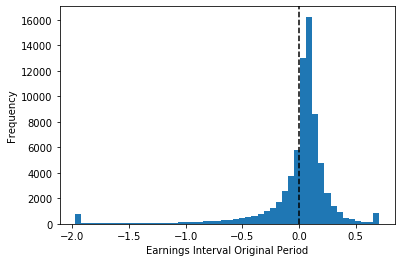

In [42]:
#Fig 3
plt.hist(funda2['earn_s'], bins=50)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Earnings Interval Original Period')
plt.ylabel('Frequency')

When plotting the results, the graphs and table resemble the original paper as can be seen in the figures above. However, for scaled change in earnings the difference between frequency before and after zero is not as drastic as the original paper.

Text(0, 0.5, 'Frequency')

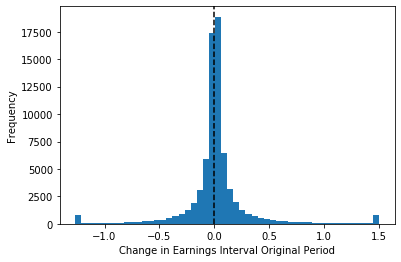

In [43]:
#Fig 1
plt.hist(funda2['scaled_earn_chng'], bins=50)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Change in Earnings Interval Original Period')
plt.ylabel('Frequency')

Resulting plot for scaled earnings matches the original paper very closely as there is a sharp increase when moving ahead from negative to positive direction.

<h1> Extension for Period 2010-2018</h1>

In [44]:
fund_new = conn.raw_sql("""
                      select gvkey, fyear, ni, csho, prcc_f, sich
                      from compa.funda where
                       (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and
                       fyear < 2019 and
                       fyear > 2007
                      """) 

In [45]:
#Using same company data extract 
funda_new = pd.merge(fund_new, company,on=['gvkey'])

In [46]:
funda_new.describe()

,fyear,ni,csho,prcc_f,sich
count,123174.000000,94171.000000,1.175510e+05,110836.000000,77789.000000
mean,2012.978843,205.860142,3.725825e+02,28.549599,4769.876268
std,3.100933,1603.671081,7.579084e+04,474.394490,2096.564366
min,2008.000000,-99289.000000,0.000000e+00,0.000001,100.000000
25%,2010.000000,-6.523000,8.859000e+00,2.250000,2890.000000
50%,2013.000000,1.528000,3.110500e+01,12.410000,4899.000000
75%,2016.000000,54.859500,8.732600e+01,28.030000,6324.000000
max,2018.000000,104821.000000,2.597496e+07,99200.000000,9998.000000


In [47]:
funda_new['sic1'] = np.where(funda_new['sich']>0,funda_new['sich'],funda_new['sic'])
funda_new = funda_new.drop(['sich','sic'],axis=1)
funda_new['sic1'] = funda_new['sic1'].astype(int)

In [48]:
# industry restriction
indexNames = funda_new[ (funda_new['sic1'] >= 4400) & (funda_new['sic1'] <= 5000) ].index
funda_new.drop(indexNames , inplace=True)
indexNames = funda_new[ (funda_new['sic1'] >= 6000) & (funda_new['sic1'] <= 6500) ].index
funda_new.drop(indexNames , inplace=True)

In [49]:
funda_new.describe()

,fyear,ni,csho,prcc_f,sic1
count,101040.000000,72691.000000,9.661200e+04,91994.000000,101040.000000
mean,2013.025465,167.476848,3.976065e+02,26.150504,4829.446140
std,3.098740,1408.861153,8.359972e+04,476.628546,2377.096089
min,2008.000000,-30860.000000,0.000000e+00,0.000001,100.000000
25%,2010.000000,-8.830000,9.261000e+00,1.650000,2836.000000
50%,2013.000000,-0.149000,3.145300e+01,11.608200,5211.000000
75%,2016.000000,34.886500,8.448700e+01,27.357500,6726.000000
max,2018.000000,104821.000000,2.597496e+07,99200.000000,9998.000000


In [50]:
funda_new['mv'] = funda_new['csho']*funda_new['prcc_f']

In [51]:
funda_new_lag1 = funda_new[['gvkey','fyear','ni','mv']].copy()

In [52]:
funda_new_lag2 = funda_new[['gvkey','fyear','mv']].copy()

In [53]:
funda_new_lag1['fyear'] = funda_new_lag1['fyear'] + 1
funda_new_lag1 = funda_new_lag1.rename(columns={'mv':'mv_lag1','ni':'ni_lag1'})
funda_new = pd.merge(funda_new,funda_new_lag1, how='left', on=['gvkey','fyear'])
funda_new = funda_new.rename(columns={'ni':'earn'})

In [54]:
funda_new = funda_new.dropna()

In [55]:
funda_new.describe()

,fyear,earn,csho,prcc_f,sic1,mv,ni_lag1,mv_lag1
count,55477.000000,55477.000000,55477.000000,55477.000000,55477.000000,5.547700e+04,55477.000000,55477.000000
mean,2013.447807,201.422465,181.220858,24.726310,4135.146367,4.327995e+03,189.055761,4022.238637
std,2.830447,1516.301490,3024.117750,454.002615,2393.859036,2.170958e+04,1499.864205,19905.908453
min,2009.000000,-23119.000000,0.000000,0.000001,100.000000,0.000000e+00,-30860.000000,0.000005
25%,2011.000000,-7.420000,22.231000,0.800000,2510.000000,2.595528e+01,-7.406000,26.656570
50%,2013.000000,0.121000,50.953000,6.490000,3661.000000,2.067027e+02,0.052000,195.586740
75%,2016.000000,48.100000,120.076000,24.100000,6794.000000,1.491699e+03,43.575000,1349.921250
max,2018.000000,104821.000000,695261.430000,99200.000000,9998.000000,1.073391e+06,104821.000000,790050.098120


In [56]:
funda_new_lag2['fyear'] = funda_new_lag2['fyear'] + 2

In [57]:
funda_new_lag2 = funda_new_lag2.rename(columns={'mv':'mv_lag2'})

In [58]:
funda_new_lag2.describe()

,fyear,mv_lag2
count,101040.000000,9.100000e+04
mean,2015.025465,3.076001e+03
std,3.098740,1.759347e+04
min,2010.000000,0.000000e+00
25%,2012.000000,2.443034e+01
50%,2015.000000,1.489201e+02
75%,2018.000000,8.823717e+02
max,2020.000000,1.073391e+06


In [59]:
funda_new = pd.merge(funda_new,funda_new_lag2, how='left', on=['gvkey','fyear'])

In [60]:
funda_new.describe()

,fyear,earn,csho,prcc_f,sic1,mv,ni_lag1,mv_lag1,mv_lag2
count,55477.000000,55477.000000,55477.000000,55477.000000,55477.000000,5.547700e+04,55477.000000,55477.000000,46222.000000
mean,2013.447807,201.422465,181.220858,24.726310,4135.146367,4.327995e+03,189.055761,4022.238637,4073.443757
std,2.830447,1516.301490,3024.117750,454.002615,2393.859036,2.170958e+04,1499.864205,19905.908453,19304.312432
min,2009.000000,-23119.000000,0.000000,0.000001,100.000000,0.000000e+00,-30860.000000,0.000005,0.000000
25%,2011.000000,-7.420000,22.231000,0.800000,2510.000000,2.595528e+01,-7.406000,26.656570,28.717713
50%,2013.000000,0.121000,50.953000,6.490000,3661.000000,2.067027e+02,0.052000,195.586740,209.987210
75%,2016.000000,48.100000,120.076000,24.100000,6794.000000,1.491699e+03,43.575000,1349.921250,1402.644615
max,2018.000000,104821.000000,695261.430000,99200.000000,9998.000000,1.073391e+06,104821.000000,790050.098120,626550.352840


In [61]:
# winsorize before doing scales.
varlist=['earn','mv_lag1','ni_lag1','mv_lag2']
for var in varlist:
    funda_new[var] = funda_new[var].replace(np.Inf, np.nan)
    funda_new[var] = np.where(funda_new[var].isnull(), np.nan, winsorize(funda_new[var], limits=(0.01,0.01)))

In [62]:
funda_new['earn_s'] = funda_new['earn']/funda_new['mv_lag1']
funda_new['scaled_earn_chng'] = (funda_new['earn'] - funda_new['ni_lag1'])/funda_new['mv_lag2']

In [63]:
funda_new2 = funda_new[['gvkey','fyear','earn_s','scaled_earn_chng']]

In [64]:
funda_new2 = funda_new2.dropna()
funda_new2.describe()

,fyear,earn_s,scaled_earn_chng
count,46222.000000,46222.000000,46222.000000
mean,2013.978019,0.123412,-0.321387
std,2.553754,68.525245,55.319804
min,2010.000000,-1914.983165,-11683.135327
25%,2012.000000,-0.142110,-0.043644
50%,2014.000000,0.009445,0.003758
75%,2016.000000,0.059873,0.054296
max,2018.000000,14521.524772,479.457072


In [65]:
varlist=['earn_s','scaled_earn_chng']
for var in varlist:
    funda_new2[var] = funda_new2[var].replace(np.Inf, np.nan)
    funda_new2[var]=np.where(funda_new2[var].isnull(), np.nan, winsorize(funda_new2[var], limits=(0.01,0.01)))

The values of mean scaled earnings are negative for all years and the standard deviation is also relatively high. There are also more firms in each year and less in total than in the original period. For scaled earnings also, we see expansion of range but with the exception that only the minimum value has gone down significantly, while the maximum value is similar to the original period.

In [66]:
# Table 1 Extenion Period Panel B
destable=funda_new2.describe().transpose()  # pooled sample
desearn_s_new=funda_new2.groupby('fyear')['earn_s'].describe() # Table 1 Panel A
desearn_s_new

,count,mean,std,min,25%,50%,75%,max
fyear,,,,,,,,
2010.0,5204.0,-0.088189,0.489095,-3.627712,-0.105006,0.029630,0.078733,0.738163
2011.0,5037.0,-0.074432,0.424412,-3.627712,-0.088690,0.027239,0.072266,0.738163
2012.0,5040.0,-0.104371,0.469338,-3.627712,-0.133452,0.019230,0.070912,0.738163
2013.0,5083.0,-0.127611,0.509468,-3.627712,-0.142029,0.013486,0.064943,0.738163
2014.0,5393.0,-0.161456,0.573371,-3.627712,-0.152491,0.003842,0.052507,0.738163
2015.0,5351.0,-0.195148,0.597996,-3.627712,-0.179790,-0.013081,0.046205,0.738163
2016.0,5288.0,-0.206864,0.644277,-3.627712,-0.194219,-0.008544,0.053140,0.738163
2017.0,5157.0,-0.158193,0.571795,-3.627712,-0.155851,0.000753,0.054955,0.738163
2018.0,4669.0,-0.121678,0.483683,-3.627712,-0.133125,0.006481,0.054985,0.738163


For the extended period of 2010-2018, we see some difference in the descriptive statistics table. For scaled change in earnings, we observe that the range of this variable has increased in the extension period, as the maximum value is 2.66 and minimum is -2.53 as compared to maximum of 1.5 and minimum of -1.26 in the original period.

In [67]:
#Table 1 Extension period Panel A
desearn_sec_new=funda_new2.groupby('fyear')['scaled_earn_chng'].describe() 
desearn_sec_new

,count,mean,std,min,25%,50%,75%,max
fyear,,,,,,,,
2010.0,5204.0,0.103620,0.664787,-2.531121,-0.029554,0.021684,0.147730,2.668443
2011.0,5037.0,0.002223,0.485506,-2.531121,-0.048275,0.006887,0.057055,2.668443
2012.0,5040.0,-0.001682,0.381281,-2.531121,-0.044892,0.000778,0.037679,2.668443
2013.0,5083.0,0.005618,0.436682,-2.531121,-0.044925,0.002731,0.046221,2.668443
2014.0,5393.0,-0.001360,0.511075,-2.531121,-0.050216,0.002075,0.047824,2.668443
2015.0,5351.0,-0.014570,0.506166,-2.531121,-0.054743,-0.000229,0.033955,2.668443
2016.0,5288.0,0.036103,0.505995,-2.531121,-0.034187,0.002954,0.053022,2.668443
2017.0,5157.0,0.006386,0.581633,-2.531121,-0.040195,0.004329,0.061287,2.668443
2018.0,4669.0,-0.003471,0.476135,-2.531121,-0.046174,0.003511,0.043264,2.668443


The plot for scaled change in earnings also shows similar pattern like the original paper but has less rigorous change going from zero ahead. Since the range of values has increased, the number of bins taken for this plot is 60. The resulting plot has huge difference between the frequencies before and after zero.

Text(0, 0.5, 'Frequency')

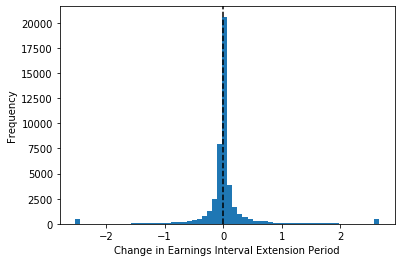

In [68]:
#Fig 1 Extension Period
plt.hist(funda_new2['scaled_earn_chng'], bins=60)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Change in Earnings Interval Extension Period')
plt.ylabel('Frequency')

For the scaled earnings plot also the number of bins was take to be 60 as the range has increased for this period. We see a similar pattern of difference between point zero and the next one.

Text(0, 0.5, 'Frequency')

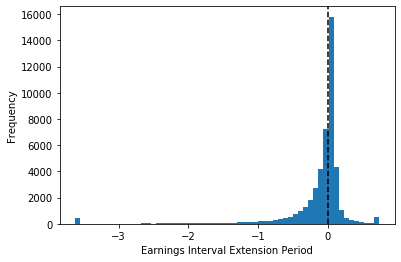

In [69]:
#Fig 3 Extension Period
plt.hist(funda_new2['earn_s'], bins=60)
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Earnings Interval Extension Period')
plt.ylabel('Frequency')